In [224]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
from xgboost import XGBClassifier
import shap

> 클러스터

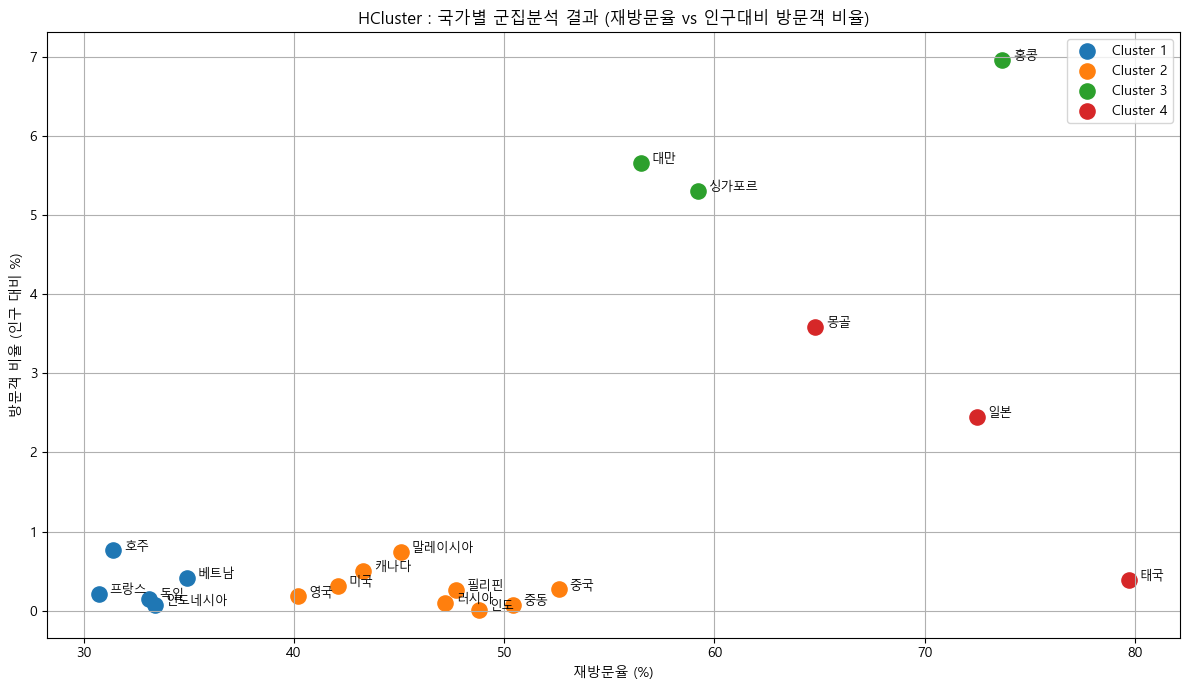

> 클러스터별 추천 종속변수

| 클러스터               | 포함 국가                         | 특성 요약                 | 추천 종속변수                               | 변수명                                                     |
| ------------------ | ----------------------------- | --------------------- | ------------------------------------- | ------------------------------------------------------- |
| **Cluster 1 (파랑)** | 호주, 프랑스, 독일, 베트남, 인도네시아       | 방문 비율/재방문율 낮음 → 신규시장  | **재방문 가능성**, **만족도**                  | `재방문여부`, `재방문의사`, `만족도`                                 |
| **Cluster 2 (주황)** | 미국, 중국, 필리핀, 말레이시아, 캐나다, 인도 등 | 방문도 재방문도 중간 → 안정시장    | **총 소비**, **1일 지출**, **추천의향**         | `1인 총소비_국제교통비 포함`, `1인 체류일별 소비금액`, `재방문의사`              |
| **Cluster 3 (초록)** | 홍콩, 대만, 싱가포르                  | 방문율·재방문율 모두 높음 → VIP층 | **1일 지출**, **항목별 소비성향**               | `1인 체류일별 소비금액`, `쇼핑장소_면세점`, `만족활동_쇼핑`, `만족활동_한류`        |
| **Cluster 4 (빨강)** | 일본, 태국, 몽골                    | 재방문율 매우 높음 → 소비 확대 대상 | **1인 총 소비**, **소비 항목별 지출**, **활동 참여** | `1인 총소비_국제교통비 포함`, `만족활동_미식`, `만족활동_전통문화`, `만족활동_오락/유흥` |


> 종속변수가 재방문 여부일 때, 설명변수 제외할 것

In [225]:
df = pd.read_csv('./data/최종모델링데이터_Final.csv')

In [226]:
# 경험 선택자 중 재방문자 비율
n_experience = df[df["Q1_관심계기_경험"] == True].shape[0]
n_experience_and_revisit = df[(df["Q1_관심계기_경험"] == True) & (df["재방문여부"] == True)].shape[0]
p_revisit_given_experience = n_experience_and_revisit / n_experience

# 새로움 선택자 중 비재방문자 비율
n_newness = df[df["Q1_관심계기_새로움"] == True].shape[0]
n_newness_and_nonrevisit = df[(df["Q1_관심계기_새로움"] == True) & (df["재방문여부"] == False)].shape[0]
p_nonrevisit_given_newness = n_newness_and_nonrevisit / n_newness

print(f"P(재방문자 | '경험') = {p_revisit_given_experience:.3%}")
print(f"P(비재방문자 | '새로움') = {p_nonrevisit_given_newness:.3%}")


P(재방문자 | '경험') = 100.000%
P(비재방문자 | '새로움') = 99.964%


In [227]:
# 새로움을 선택했지만 재방문자인 사람
mask = (df["Q1_관심계기_새로움"] == True) & (df["재방문여부"] == True)
df_exception = df[mask]

print(f"예외 행 수: {df_exception.shape[0]}")
df_exception

예외 행 수: 1


,재방문여부,여행형태_개별여행,여행형태_에어텔,여행형태_단체여행,Q1_응답대상,Q1_관심계기_경제성,Q1_관심계기_경험,Q1_관심계기_기타,Q1_관심계기_문화콘텐츠,Q1_관심계기_새로움,...,국가_인도네시아,국가_일본,국가_중국,국가_중동,국가_캐나다,국가_태국,국가_프랑스,국가_필리핀,국가_호주,국가_홍콩
13076,1,True,False,False,1,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False


# Cluster 1

## 1. 종속변수 - 재방문 여부

### (1) 기본 모델

In [228]:
# 클러스터 국가 리스트
cluster2_countries = [
    '국가_프랑스', '국가_베트남', '국가_인도네시아', '국가_호주', '국가_독일'
]

# 클러스터 국가 리스트 중 하나라도 True인 행만 필터링
cluster2_mask = df[cluster2_countries].any(axis=1)
df_c2 = df[cluster2_mask].copy()

In [229]:
# 종속변수
y = df_c2["재방문여부"]

# 가중치와 종속변수를 설명변수에서 제외
X = df_c2.drop(columns=["재방문여부", '가중치', 'Q1_관심계기_경험', 'Q1_관심계기_새로움'])

# 문자열인 열은 설명변수에서 제외
X = X.select_dtypes(exclude=['object'])

weights = df_c2["가중치"]

In [230]:
# train / test 세트 분리
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, stratify=y, random_state=42
)

# 기본 모델 학습
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [231]:
# 예측값 생성
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [232]:
y_proba = model.predict_proba(X_test)[:, 1]

# 최적 threshold 계산
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))



▶ [XGBoost 결과: Threshold = 0.280]
Accuracy     : 0.671
Precision    : 0.506
Recall       : 0.708
F1 Score     : 0.590
ROC AUC      : 0.723

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.816     0.653     0.725 222284.04159845808
           1      0.506     0.708     0.590 111862.45842723837

    accuracy                          0.671 334146.50002569647
   macro avg      0.661     0.680     0.658 334146.50002569647
weighted avg      0.712     0.671     0.680 334146.50002569647


▶ [혼동 행렬]
[[357 185]
 [ 76 195]]


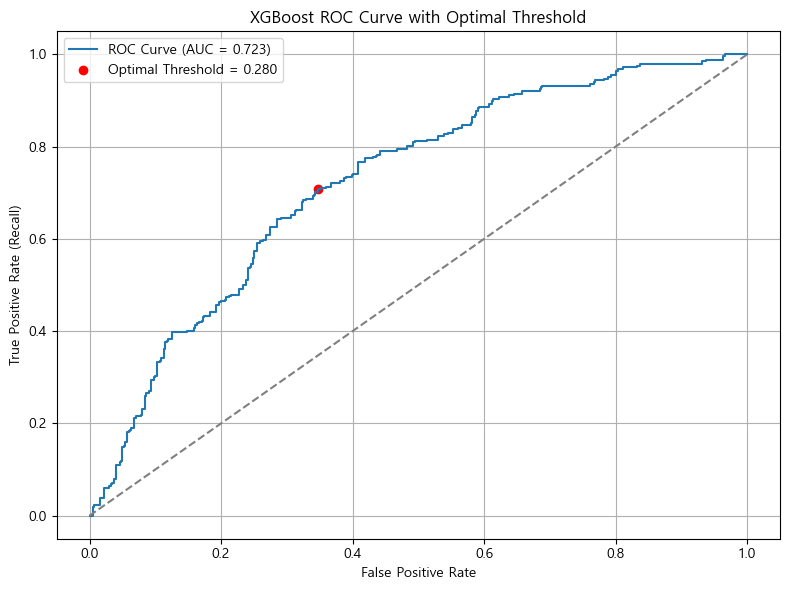

In [233]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

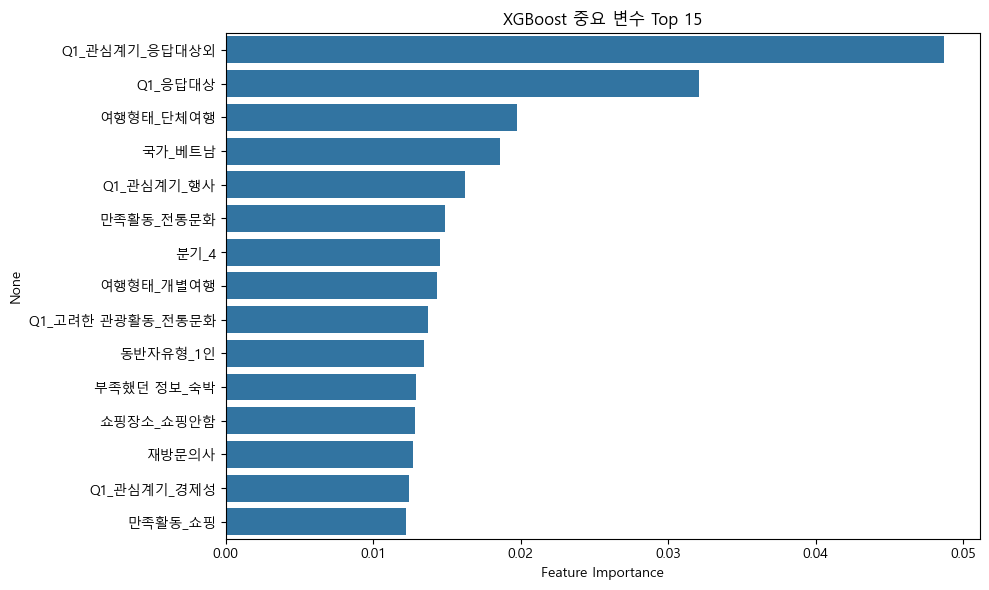

In [234]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

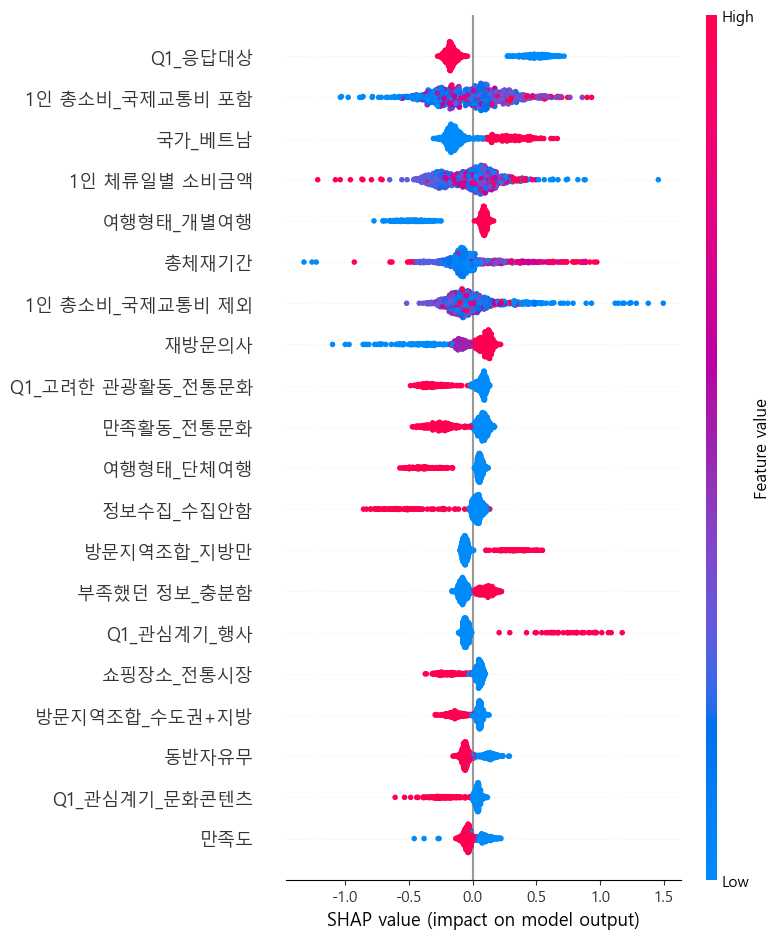

In [235]:
explainer = shap.Explainer(model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test, plot_type="dot")

In [236]:
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    w_tr, w_te = weights.iloc[train_idx], weights.iloc[test_idx]

    model_cv = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model_cv.fit(X_tr, y_tr, sample_weight=w_tr)
    y_prob = model_cv.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob, sample_weight=w_te)
    auc_scores.append(auc)

print("▶ Cross-Validation AUC Scores:", auc_scores)
print("▶ Mean AUC:", np.mean(auc_scores))
print("▶ Std AUC :", np.std(auc_scores))

▶ Cross-Validation AUC Scores: [0.7293960685076278, 0.7787876408745822, 0.7355424639175032, 0.6954364675824838, 0.7386302483458871]
▶ Mean AUC: 0.7355585778456168
▶ Std AUC : 0.026555404583590802


In [292]:
import pandas as pd
import numpy as np
import shap

# 1. SHAP 계산 (너가 이미 실행한 부분)
# explainer = shap.Explainer(model)
# shap_values = explainer(X_test)

# 2. SHAP 값을 numpy 배열로 추출
shap_array = shap_values.values  # (n_samples, n_features)
shap_df = pd.DataFrame(shap_array, columns=X_test.columns)

# 3. 통계 요약
summary = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_array).mean(axis=0),
    'mean_shap': shap_array.mean(axis=0),
    'std_shap': shap_array.std(axis=0),
    'positive_ratio': (shap_array > 0).mean(axis=0)
})

# 4. 방향성 분류
summary['directionality'] = np.where(summary['positive_ratio'] > 0.9, 'strong_positive',
                            np.where(summary['positive_ratio'] < 0.1, 'strong_negative', 'neutral'))

# 5. 영향력 상위 변수 필터링
threshold = summary['mean_abs_shap'].quantile(0.8)
top_influential = summary[summary['mean_abs_shap'] > threshold]

# 6. 이진 변수만 필터링 (0/1만 존재하는 변수)
binary_cols = [col for col in X_test.columns if set(X_test[col].dropna().unique()).issubset({0, 1})]
summary_binary = top_influential[top_influential['feature'].isin(binary_cols)]

# 7. 출력
print("🎯 SHAP 기반 정책 개입 가능 후보 변수 (0/1 변수 중 영향력 상위 + 방향성 명확한 것):")
summary_binary[['feature', 'mean_abs_shap', 'mean_shap', 'directionality']].sort_values('mean_abs_shap', ascending=False)


🎯 SHAP 기반 정책 개입 가능 후보 변수 (0/1 변수 중 영향력 상위 + 방향성 명확한 것):


,feature,mean_abs_shap,mean_shap,directionality
43,부족했던 정보_충분함,0.242691,0.007790,neutral
79,성별_남성,0.212832,-0.015169,neutral
50,동반자유형_친구/동료,0.177122,0.035006,neutral
0,여행형태_개별여행,0.150247,0.028193,neutral
60,만족활동_전통문화,0.143248,0.004240,neutral
73,쇼핑장소_백화점,0.131655,0.002009,neutral
44,동반자유무,0.110536,0.018345,neutral
53,만족활동_미식,0.095627,-0.013103,neutral
8,Q1_관심계기_접근성,0.093078,0.002459,neutral
75,쇼핑장소_전통시장,0.091054,0.016934,neutral


### (2) 그리드 서치 모델

| 단계 | 파라미터                               | 설명          |
| -- | ---------------------------------- | ----------- |
| ①  | `max_depth`, `min_child_weight`    | 모델 복잡도 조절   |
| ②  | `subsample`, `colsample_bytree`    | 과적합 방지      |
| ③  | `learning_rate`, `n_estimators`    | 학습 속도/횟수 조절 |
| ④  | `gamma`, `reg_alpha`, `reg_lambda` | 규제 조절       |


In [237]:
# 1단계 파라미터 그리드
param_grid_1 = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5]
}

# 기본 모델
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    subsample=1,
    colsample_bytree=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_1 = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_1,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_1.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_1.best_params_)
print("Best AUC Score:", grid_search_1.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 3, 'min_child_weight': 1}
Best AUC Score: 0.7230858303444414


In [238]:
# 1단계 결과 반영
best_model_1 = grid_search_1.best_estimator_
best_max_depth        = best_model_1.get_params()['max_depth']
best_min_child_weight = best_model_1.get_params()['min_child_weight']

# 2단계 파라미터 그리드
param_grid_2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 1단계 최적값을 고정한 모델
xgb_clf_2 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_2 = GridSearchCV(
    estimator=xgb_clf_2,
    param_grid=param_grid_2,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_2.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (2단계):", grid_search_2.best_params_)
print("Best AUC Score:", grid_search_2.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (2단계): {'colsample_bytree': 0.6, 'subsample': 0.8}
Best AUC Score: 0.7279207360713983


In [239]:
# 2단계까지 결과 반영
best_model_2 = grid_search_2.best_estimator_
best_max_depth        = best_model_2.get_params()['max_depth']
best_min_child_weight = best_model_2.get_params()['min_child_weight']
best_subsample        = best_model_2.get_params()['subsample']
best_colsample_bytree = best_model_2.get_params()['colsample_bytree']

# 3단계 파라미터 그리드
param_grid_3 = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# 이전 최적값을 고정한 모델
xgb_clf_3 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_3 = GridSearchCV(
    estimator=xgb_clf_3,
    param_grid=param_grid_3,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_3.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (3단계):", grid_search_3.best_params_)
print("Best AUC Score:", grid_search_3.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (3단계): {'learning_rate': 0.1, 'n_estimators': 100}
Best AUC Score: 0.7279207360713983


In [240]:
# 3단계까지 결과 반영
best_model_3 = grid_search_3.best_estimator_
best_max_depth        = best_model_3.get_params()['max_depth']
best_min_child_weight = best_model_3.get_params()['min_child_weight']
best_subsample        = best_model_3.get_params()['subsample']
best_colsample_bytree = best_model_3.get_params()['colsample_bytree']
best_learning_rate    = best_model_3.get_params()['learning_rate']
best_n_estimators     = best_model_3.get_params()['n_estimators']

# 4단계 파라미터 그리드
param_grid_4 = {
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

# 이전 최적값을 고정한 모델
xgb_clf_4 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_4 = GridSearchCV(
    estimator=xgb_clf_4,
    param_grid=param_grid_4,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_4.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (4단계):", grid_search_4.best_params_)
print("Best AUC Score:", grid_search_4.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters (4단계): {'gamma': 0.5, 'reg_alpha': 1.0, 'reg_lambda': 0.5}
Best AUC Score: 0.7279815011428686


In [241]:
best_model = grid_search_4.best_estimator_

In [242]:
best_params_4 = grid_search_4.best_params_

best_max_depth        = best_model.get_params()['max_depth']
best_min_child_weight = best_model.get_params()['min_child_weight']
best_subsample        = best_model.get_params()['subsample']
best_colsample_bytree = best_model.get_params()['colsample_bytree']
best_learning_rate    = best_model.get_params()['learning_rate']
best_n_estimators     = best_model.get_params()['n_estimators']
best_gamma            = best_params_4.get('gamma', 0)
best_reg_alpha        = best_params_4.get('reg_alpha', 0)
best_reg_lambda       = best_params_4.get('reg_lambda', 1)

In [243]:
print("▶ 최적 파라미터")
print(f"max_depth        = {best_max_depth}")
print(f"min_child_weight = {best_min_child_weight}")
print(f"subsample        = {best_subsample}")
print(f"colsample_bytree = {best_colsample_bytree}")
print(f"learning_rate    = {best_learning_rate}")
print(f"n_estimators     = {best_n_estimators}")
print(f"gamma            = {best_gamma}")
print(f"reg_alpha        = {best_reg_alpha}")
print(f"reg_lambda       = {best_reg_lambda}")

▶ 최적 파라미터
max_depth        = 3
min_child_weight = 1
subsample        = 0.8
colsample_bytree = 0.6
learning_rate    = 0.1
n_estimators     = 100
gamma            = 0.5
reg_alpha        = 1.0
reg_lambda       = 0.5


In [244]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))


▶ [XGBoost 결과: Threshold = 0.348]
Accuracy     : 0.720
Precision    : 0.573
Recall       : 0.641
F1 Score     : 0.605
ROC AUC      : 0.744

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.808     0.760     0.783 222284.04159845808
           1      0.573     0.641     0.605 111862.45842723837

    accuracy                          0.720 334146.50002569647
   macro avg      0.691     0.701     0.694 334146.50002569647
weighted avg      0.730     0.720     0.724 334146.50002569647


▶ [혼동 행렬]
[[409 133]
 [ 94 177]]


클래스별 개수:
재방문여부
0    1807
1     902
Name: count, dtype: int64

클래스별 비율 (%):
재방문여부
0    66.7
1    33.3
Name: proportion, dtype: float64


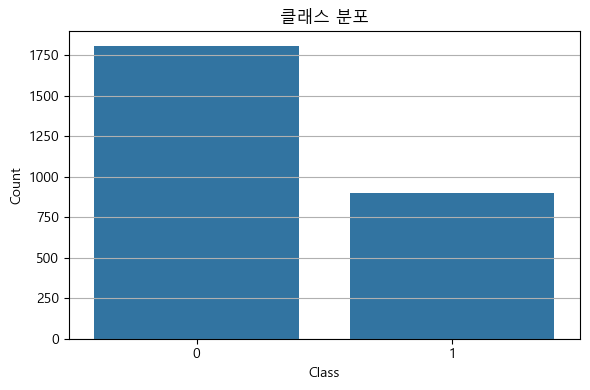

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스 분포 개수
class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

print("클래스별 개수:")
print(class_counts)
print("\n클래스별 비율 (%):")
print(class_percent.round(2))

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("클래스 분포")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

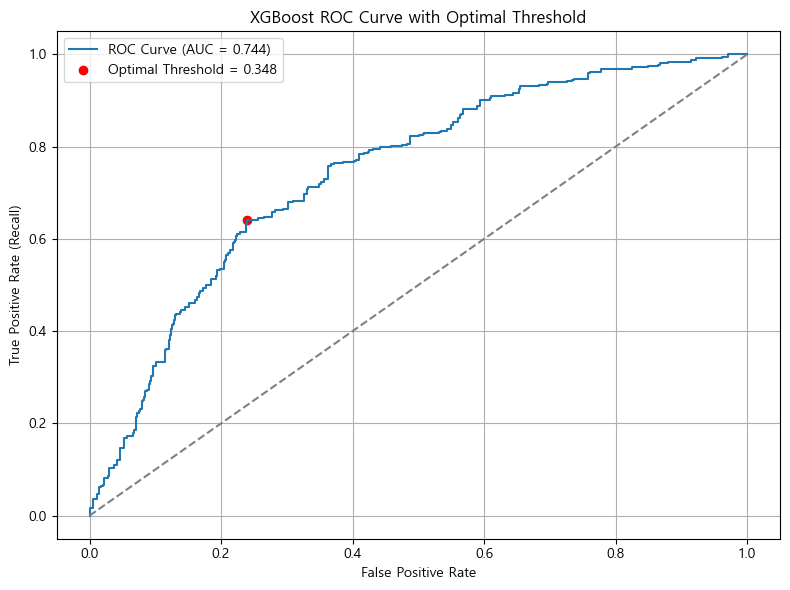

In [246]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

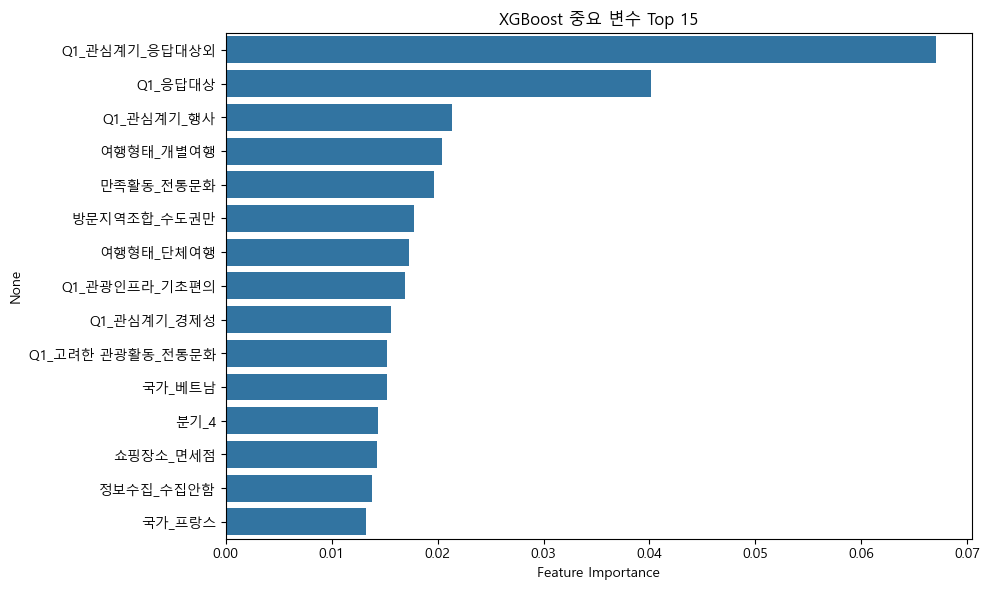

In [247]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

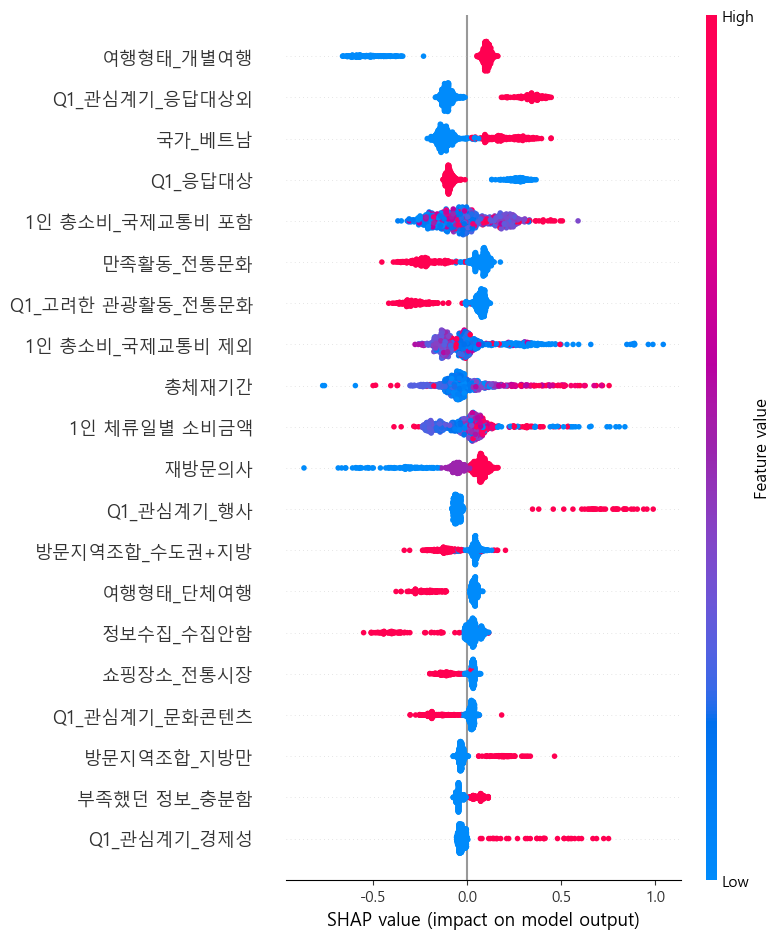

In [248]:
explainer = shap.Explainer(best_model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")

In [249]:
# 4단계 최종 모델을 그대로 사용
final_model = XGBClassifier(**best_model.get_params())

In [250]:
# StratifiedKFold 정의
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# AUC 기준으로 교차검증 수행
cv_scores = cross_val_score(
    final_model,
    X,
    y,
    cv=cv,
    scoring='roc_auc'
)

# 결과 출력
print("▶ Cross-Validation AUC Scores:", cv_scores)
print("▶ Mean AUC:", np.mean(cv_scores))
print("▶ Std AUC:", np.std(cv_scores))

▶ Cross-Validation AUC Scores: [0.73779097 0.76764971 0.73838244 0.71876918 0.73993536]
▶ Mean AUC: 0.7405055359150032
▶ Std AUC: 0.015629951478821562


### Cluster1 최종 모델: 그리드 서치 모델

### (3) 시뮬레이션 - 타깃에 대해

### 최종 모델이 기본 모델일 때

#### 가중치 반영 X ver

In [251]:
# ─────────── 기본 모델 기반 시뮬레이션 ───────────
# 조건부 타깃
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['Q1_관심계기_행사'] == False) &
    (X_test['Q1_고려한 관광활동_전통문화'] == False)
)
X_target = X_test[target_mask].copy()
proba_before = model.predict_proba(X_target)[:, 1]

# 단일 선택형 변수 처리
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
# 고려한 관광활동 변수 리스트
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]


# 변수 개입 시나리오 적용
X_sim = X_target.copy()
X_sim[travel_cols] = False
X_sim['여행형태_개별여행'] = True

X_sim[interest_cols] = False
X_sim['Q1_관심계기_행사'] = True

X_sim[activity_cols] = False
X_sim['Q1_고려한 관광활동_전통문화'] = True

# 변화 후 예측 및 요약
proba_after = model.predict_proba(X_sim)[:, 1]
delta = proba_after - proba_before #delta = After - Before는 정책 개입의 기대 효과 (확률 기준 변화량)
summary_model = pd.DataFrame({'Before': proba_before, 'After': proba_after, 'Change': delta})

#개입 후 예측 확률이 optimal_threshold를 넘으면 재방문 가능성 상승자로 간주
#“정책 개입 시 얼마나 많은 사람들이 재방문자로 바뀔 가능성이 있는가”를 판단
summary_model['Lifted'] = (summary_model['After'] >= optimal_threshold).astype(int)

# 분석 요약 출력
print("\n[기본 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_model)}")
print(f"▶ 평균 확률 변화        : {delta.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_model['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_model['Lifted'].mean() * 100:.2f}%")
# 예를 들어 재방문 확률 0.25였는데, 변수 조작 후에는 0.88로 상승
print(f"▶ 최대 변화             : {delta.max():.4f}")
# -이면 오히려 감소한 경우
print(f"▶ 최소 변화             : {delta.min():.4f}")



[기본 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 94
▶ 평균 확률 변화        : 0.2807
▶ 재방문 확률 상승자 수 : 62명
▶ 상승 비율             : 65.96%
▶ 최대 변화             : 0.6323
▶ 최소 변화             : -0.0804


#### 가중치 반영 O ver

In [295]:
# ─────────── 조건부 타깃 정의 ───────────
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['Q1_관심계기_행사'] == False) &
    (X_test['Q1_고려한 관광활동_전통문화'] == False)
)
X_target = X_test[target_mask].copy()
weights_target = w_test[target_mask].copy()

# ─────────── 단일 선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim = X_target.copy()
X_sim[travel_cols] = False
X_sim['여행형태_개별여행'] = True

X_sim[interest_cols] = False
X_sim['Q1_관심계기_행사'] = True

X_sim[activity_cols] = False
X_sim['Q1_고려한 관광활동_전통문화'] = True

# ─────────── 예측 및 변화량 계산 ───────────
proba_before = model.predict_proba(X_target)[:, 1]
proba_after = model.predict_proba(X_sim)[:, 1]
delta = proba_after - proba_before

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_model = pd.DataFrame({
    'Before': proba_before,
    'After': proba_after,
    'Change': delta
})
summary_model['Lifted'] = (summary_model['After'] >= optimal_threshold).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array = weights_target.to_numpy()
weighted_mean_delta = np.average(delta, weights=weights_array)
lifted_weights = weights_array[summary_model['Lifted'].to_numpy() == 1]
weighted_lifted_sum = lifted_weights.sum()
total_weight = weights_array.sum()
weighted_lifted_ratio = (weighted_lifted_sum / total_weight) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_idx = np.argmax(delta)
bottom_idx = np.argmin(delta)

# ─────────── 전체 비재방문자 중 타깃 비중 계산 ───────────
non_repeat_mask_all = (y_test == 0)
total_nonrepeat_weight = w_test[non_repeat_mask_all].sum()
target_weight_ratio = (total_weight / total_nonrepeat_weight) * 100


# ─────────── 최종 출력 ───────────
print("\n📘 [기본 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]")
print(f"▶ 가중 타깃 수             : {total_weight:.0f}명")
print(f"▶ 조건부 타깃 비중 (전체 비재방문자 중) : {target_weight_ratio:.2f}%")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio:.2f}%")
print(f"▶ 최대 변화                : {delta.max():.4f}")
print(f"▶ 최소 변화                : {delta.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before[top_idx]:.4f} → {proba_after[top_idx]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before[bottom_idx]:.4f} → {proba_after[bottom_idx]:.4f}")


📘 [기본 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]
▶ 가중 타깃 수             : 116608명
▶ 조건부 타깃 비중 (전체 비재방문자 중) : 38.62%
▶ 평균 확률 변화 (가중)    : 0.1784
▶ 재방문 상승자 수 (가중)  : 79811명
▶ 상승 비율 (가중)         : 68.44%
▶ 최대 변화                : 0.4970
▶ 최소 변화                : -0.0897
▶ 변화량 최댓값 응답자 Before/After: 0.4087 → 0.9057
▶ 변화량 최솟값 응답자 Before/After: 0.8994 → 0.8098


In [302]:
# ─────────── 전체 재방문 확률 증가량 계산 ───────────
# 단위: 평균 변화량 * 전체에서 차지하는 비중
overall_delta = (target_weight_ratio / 100) * weighted_mean_delta

print(f"\n📘 [전체 관점에서의 재방문 확률 상승 효과]")
print(f"▶ 전체 비재방문자 중 타깃이 차지하는 비중       : {target_weight_ratio:.2f}%")
print(f"▶ 해당 타깃의 평균 재방문 확률 변화량 (가중)     : {weighted_mean_delta:.4f}")
print(f"▶ 전체 재방문 확률 증가 기여 (타깃 비중 × 변화량) : {overall_delta:.4f}")



📘 [전체 관점에서의 재방문 확률 상승 효과]
▶ 전체 비재방문자 중 타깃이 차지하는 비중       : 38.62%
▶ 해당 타깃의 평균 재방문 확률 변화량 (가중)     : 0.1784
▶ 전체 재방문 확률 증가 기여 (타깃 비중 × 변화량) : 0.0689


### 최종 모델이 그리드 서치 모델일때

#### 가중치 반영 X ver

In [253]:
# ─────────── 그리드서치 최적 모델 기반 시뮬레이션 ───────────
# 조건부 타깃 재사용
X_target_gs = X_test[target_mask].copy()
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]

# 변수 개입 동일하게 적용
X_sim_gs = X_target_gs.copy()
X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs[interest_cols] = False
X_sim_gs['Q1_관심계기_행사'] = True

X_sim_gs['Q1_고려한 관광활동_전통문화'] = True

# 변화 후 예측 및 요약
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# 전체 test 세트 기준 best_model용 threshold 계산
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_best = pd.DataFrame({'Before': proba_before_gs, 'After': proba_after_gs, 'Change': delta_gs})
summary_best['Lifted'] = (summary_best['After'] >= optimal_threshold_gs).astype(int)

# 분석 요약 출력
print("\n[그리드서치 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_best)}")
print(f"▶ 평균 확률 변화        : {delta_gs.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_best['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_best['Lifted'].mean() * 100:.2f}%")
print(f"▶ 최대 변화             : {delta_gs.max():.4f}")
print(f"▶ 최소 변화             : {delta_gs.min():.4f}")



[그리드서치 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 94
▶ 평균 확률 변화        : 0.2868
▶ 재방문 확률 상승자 수 : 75명
▶ 상승 비율             : 79.79%
▶ 최대 변화             : 0.5632
▶ 최소 변화             : -0.0748


#### 가중치 반영 O ver

In [303]:
# ─────────── 조건부 타깃 정의 ───────────
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['Q1_관심계기_행사'] == False) &
    (X_test['Q1_고려한 관광활동_전통문화'] == False)
)
X_target_gs = X_test[target_mask].copy()
weights_target_gs = w_test[target_mask].copy()  # 🎯 가중치 추출

# ─────────── 단일 선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim_gs = X_target_gs.copy()
X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs[interest_cols] = False
X_sim_gs['Q1_관심계기_행사'] = True

X_sim_gs[activity_cols] = False
X_sim_gs['Q1_고려한 관광활동_전통문화'] = True

# ─────────── 예측 및 변화량 계산 ───────────
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# ─────────── threshold 계산 (전체 test 기준) ───────────
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_gs = pd.DataFrame({
    'Before': proba_before_gs,
    'After': proba_after_gs,
    'Change': delta_gs
})
summary_gs['Lifted'] = (summary_gs['After'] >= optimal_threshold_gs).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array_gs = weights_target_gs.to_numpy()
assert len(weights_array_gs) == len(delta_gs), "가중치와 delta 길이 불일치"

# 평균 변화량
weighted_mean_delta_gs = np.average(delta_gs, weights=weights_array_gs)

# 상승자 가중치 합
lifted_weights_gs = weights_array_gs[summary_gs['Lifted'].to_numpy() == 1]
weighted_lifted_sum_gs = lifted_weights_gs.sum()

# 전체 가중 타깃 수
total_weight_gs = weights_array_gs.sum()

# 상승 비율
weighted_lifted_ratio_gs = (weighted_lifted_sum_gs / total_weight_gs) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_lift_idx = np.argmax(delta_gs)
bottom_lift_idx = np.argmin(delta_gs)

# ─────────── 전체 비재방문자 중 조건부 타깃 비중 계산 ───────────
non_repeat_mask_all = (y_test == 0)
total_nonrepeat_weight = w_test[non_repeat_mask_all].sum()
target_weight_ratio_gs = (total_weight_gs / total_nonrepeat_weight) * 100

# ─────────── 최종 출력 ───────────
print("\n📘 [그리드서치 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]")
print(f"▶ 가중 타깃 수             : {total_weight_gs:.0f}명")
print(f"▶ 조건부 타깃 비중 (전체 비재방문자 중) : {target_weight_ratio_gs:.2f}%")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta_gs:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum_gs:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio_gs:.2f}%")
print(f"▶ 최대 변화                : {delta_gs.max():.4f}")
print(f"▶ 최소 변화                : {delta_gs.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before_gs[top_lift_idx]:.4f} → {proba_after_gs[top_lift_idx]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before_gs[bottom_lift_idx]:.4f} → {proba_after_gs[bottom_lift_idx]:.4f}")



📘 [그리드서치 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]
▶ 가중 타깃 수             : 116608명
▶ 조건부 타깃 비중 (전체 비재방문자 중) : 38.62%
▶ 평균 확률 변화 (가중)    : 0.0691
▶ 재방문 상승자 수 (가중)  : 32849명
▶ 상승 비율 (가중)         : 28.17%
▶ 최대 변화                : 0.2781
▶ 최소 변화                : -0.0112
▶ 변화량 최댓값 응답자 Before/After: 0.4221 → 0.7002
▶ 변화량 최솟값 응답자 Before/After: 0.6264 → 0.6152


In [304]:
# ─────────── 전체 재방문 확률 증가량 계산 (그리드서치 모델 기준) ───────────
overall_delta_gs = (target_weight_ratio_gs / 100) * weighted_mean_delta_gs

print("\n📘 [전체 관점에서의 재방문 확률 상승 효과 - 그리드서치 모델 기준]")
print(f"▶ 전체 비재방문자 중 타깃이 차지하는 비중       : {target_weight_ratio_gs:.2f}%")
print(f"▶ 해당 타깃의 평균 재방문 확률 변화량 (가중)     : {weighted_mean_delta_gs:.4f}")
print(f"▶ 전체 재방문 확률 증가 기여 (타깃 비중 × 변화량) : {overall_delta_gs:.4f}")



📘 [전체 관점에서의 재방문 확률 상승 효과 - 그리드서치 모델 기준]
▶ 전체 비재방문자 중 타깃이 차지하는 비중       : 38.62%
▶ 해당 타깃의 평균 재방문 확률 변화량 (가중)     : 0.0691
▶ 전체 재방문 확률 증가 기여 (타깃 비중 × 변화량) : 0.0267


### (4) 시뮬레이션 - 전체 비재방문객에 대해

### 최종 모델이 기본 모델일 때

#### 가중치 반영 X ver

In [255]:
# ─────────── 전체 재방문X 대상: 기본 모델 ───────────

# 전체 재방문여부 = 0인 응답자
X_all = X_test.copy()
non_repeat_mask = (y_test == 0)
X_non_repeat = X_all[non_repeat_mask].copy()
proba_before_all = model.predict_proba(X_non_repeat)[:, 1]

# 단일선택형 변수 그룹
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# 변수 개입
X_sim_all = X_non_repeat.copy()
X_sim_all[travel_cols] = False
X_sim_all['여행형태_개별여행'] = True
X_sim_all[interest_cols] = False
X_sim_all['Q1_관심계기_행사'] = True
X_sim_all[activity_cols] = False
X_sim_all['Q1_고려한 관광활동_전통문화'] = True

# 예측 및 변화량
proba_after_all = model.predict_proba(X_sim_all)[:, 1]
delta_all = proba_after_all - proba_before_all

summary_all = pd.DataFrame({
    'Before': proba_before_all,
    'After': proba_after_all,
    'Change': delta_all
})
summary_all['Lifted'] = (summary_all['After'] >= optimal_threshold).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 기본 모델]")
print(f"▶ 전체 대상 수           : {len(summary_all)}")
print(f"▶ 평균 확률 변화         : {delta_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 기본 모델]
▶ 전체 대상 수           : 542
▶ 평균 확률 변화         : 0.1241
▶ 재방문 가능성 상승자 수 : 286명
▶ 상승 비율               : 52.77%
▶ 최대 변화               : 0.6323
▶ 최소 변화               : -0.3932


#### 가중치 반영 O ver

In [305]:
# ─────────── 전체 재방문X 대상: 기본 모델 ───────────

# 전체 재방문여부 = 0인 응답자
non_repeat_mask = (y_test == 0)
X_non_repeat = X_test[non_repeat_mask].copy()
weights_non_repeat = w_test[non_repeat_mask].copy()

# 예측 전 확률
proba_before_all = model.predict_proba(X_non_repeat)[:, 1]

# ─────────── 단일선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim_all = X_non_repeat.copy()
X_sim_all[travel_cols] = False
X_sim_all['여행형태_개별여행'] = True

X_sim_all[interest_cols] = False
X_sim_all['Q1_관심계기_행사'] = True

X_sim_all[activity_cols] = False
X_sim_all['Q1_고려한 관광활동_전통문화'] = True

# ─────────── 예측 및 변화량 계산 ───────────
proba_after_all = model.predict_proba(X_sim_all)[:, 1]
delta_all = proba_after_all - proba_before_all

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_all = pd.DataFrame({
    'Before': proba_before_all,
    'After': proba_after_all,
    'Change': delta_all
})
summary_all['Lifted'] = (summary_all['After'] >= optimal_threshold).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array_all = weights_non_repeat.to_numpy()

# 평균 확률 변화 (가중)
weighted_mean_delta_all = np.average(delta_all, weights=weights_array_all)

# 재방문 확률 상승자 수 (가중치 합)
lifted_weights_all = weights_array_all[summary_all['Lifted'].to_numpy() == 1]
weighted_lifted_sum_all = lifted_weights_all.sum()

# 전체 가중 대상 수
total_weight_all = weights_array_all.sum()

# 상승 비율 (가중 기준)
weighted_lifted_ratio_all = (weighted_lifted_sum_all / total_weight_all) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_idx_all = np.argmax(delta_all)
bottom_idx_all = np.argmin(delta_all)



# ─────────── 최종 출력 ───────────
print("\n📘 [전체 비재방문자 시뮬레이션 - 기본 모델, 가중치 반영]")
print(f"▶ 가중 대상 수             : {total_weight_all:.0f}명")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta_all:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum_all:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio_all:.2f}%")
print(f"▶ 최대 변화                : {delta_all.max():.4f}")
print(f"▶ 최소 변화                : {delta_all.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before_all[top_idx_all]:.4f} → {proba_after_all[top_idx_all]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before_all[bottom_idx_all]:.4f} → {proba_after_all[bottom_idx_all]:.4f}")



📘 [전체 비재방문자 시뮬레이션 - 기본 모델, 가중치 반영]
▶ 가중 대상 수             : 301928명
▶ 평균 확률 변화 (가중)    : 0.1063
▶ 재방문 상승자 수 (가중)  : 164350명
▶ 상승 비율 (가중)         : 54.43%
▶ 최대 변화                : 0.4970
▶ 최소 변화                : -0.2250
▶ 변화량 최댓값 응답자 Before/After: 0.4087 → 0.9057
▶ 변화량 최솟값 응답자 Before/After: 0.6387 → 0.4137


In [306]:
# ─────────── 전체 재방문 확률 증가 기여 계산 ───────────
overall_delta_all = weighted_mean_delta_all  # 전체 대상이므로 비중 = 1

print("\n📘 [전체 관점에서의 재방문 확률 상승 효과 - 전체 비재방문자 대상]")
print(f"▶ 전체 비재방문자 평균 재방문 확률 변화량 (가중): {weighted_mean_delta_all:.4f}")
print(f"▶ 전체 재방문 확률 증가 기여                    : {overall_delta_all:.4f}")



📘 [전체 관점에서의 재방문 확률 상승 효과 - 전체 비재방문자 대상]
▶ 전체 비재방문자 평균 재방문 확률 변화량 (가중): 0.1063
▶ 전체 재방문 확률 증가 기여                    : 0.1063


### 최종 모델이 그리드 서치 모델일 때

#### 가중치 반영 X ver

In [257]:
# ─────────── 전체 재방문X 대상: 그리드서치 모델 ───────────

# 대상 재사용
X_non_repeat_gs = X_test[y_test == 0].copy()
proba_before_gs_all = best_model.predict_proba(X_non_repeat_gs)[:, 1]

# 변수 개입
X_sim_gs_all = X_non_repeat_gs.copy()
X_sim_gs_all[travel_cols] = False
X_sim_gs_all['여행형태_개별여행'] = True
X_sim_gs_all[interest_cols] = False
X_sim_gs_all['Q1_관심계기_행사'] = True
X_sim_gs_all[activity_cols] = False
X_sim_gs_all['Q1_고려한 관광활동_전통문화'] = True

# 예측 및 변화량
proba_after_gs_all = best_model.predict_proba(X_sim_gs_all)[:, 1]
delta_gs_all = proba_after_gs_all - proba_before_gs_all

# best_model용 threshold 재계산 (전체 test 기준)
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_gs_all = pd.DataFrame({
    'Before': proba_before_gs_all,
    'After': proba_after_gs_all,
    'Change': delta_gs_all
})
summary_gs_all['Lifted'] = (summary_gs_all['After'] >= optimal_threshold_gs).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]")
print(f"▶ 전체 대상 수           : {len(summary_gs_all)}")
print(f"▶ 평균 확률 변화         : {delta_gs_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_gs_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_gs_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_gs_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_gs_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]
▶ 전체 대상 수           : 542
▶ 평균 확률 변화         : 0.1311
▶ 재방문 가능성 상승자 수 : 328명
▶ 상승 비율               : 60.52%
▶ 최대 변화               : 0.5922
▶ 최소 변화               : -0.3378


#### 가중치 반영 O ver

In [307]:
# ─────────── 전체 재방문X 대상: 그리드서치 모델 ───────────

# 대상 필터
non_repeat_mask_gs = (y_test == 0)
X_non_repeat_gs = X_test[non_repeat_mask_gs].copy()
weights_non_repeat_gs = w_test[non_repeat_mask_gs].copy()

# 예측 전 확률
proba_before_gs_all = best_model.predict_proba(X_non_repeat_gs)[:, 1]

# ─────────── 단일선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim_gs_all = X_non_repeat_gs.copy()
X_sim_gs_all[travel_cols] = False
X_sim_gs_all['여행형태_개별여행'] = True

X_sim_gs_all[interest_cols] = False
X_sim_gs_all['Q1_관심계기_행사'] = True

X_sim_gs_all[activity_cols] = False
X_sim_gs_all['Q1_고려한 관광활동_전통문화'] = True

# ─────────── 예측 및 변화량 계산 ───────────
proba_after_gs_all = best_model.predict_proba(X_sim_gs_all)[:, 1]
delta_gs_all = proba_after_gs_all - proba_before_gs_all

# ─────────── threshold 재계산 (전체 test 기준) ───────────
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_gs_all = pd.DataFrame({
    'Before': proba_before_gs_all,
    'After': proba_after_gs_all,
    'Change': delta_gs_all
})
summary_gs_all['Lifted'] = (summary_gs_all['After'] >= optimal_threshold_gs).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array_gs_all = weights_non_repeat_gs.to_numpy()

# 평균 확률 변화 (가중)
weighted_mean_delta_gs_all = np.average(delta_gs_all, weights=weights_array_gs_all)

# 재방문 상승자 가중치 합
lifted_weights_gs_all = weights_array_gs_all[summary_gs_all['Lifted'].to_numpy() == 1]
weighted_lifted_sum_gs_all = lifted_weights_gs_all.sum()

# 전체 가중 대상 수
total_weight_gs_all = weights_array_gs_all.sum()

# 상승 비율 (가중)
weighted_lifted_ratio_gs_all = (weighted_lifted_sum_gs_all / total_weight_gs_all) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_idx_gs_all = np.argmax(delta_gs_all)
bottom_idx_gs_all = np.argmin(delta_gs_all)

# ─────────── 최종 출력 ───────────
print("\n📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델, 가중치 반영]")
print(f"▶ 가중 대상 수             : {total_weight_gs_all:.0f}명")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta_gs_all:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum_gs_all:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio_gs_all:.2f}%")
print(f"▶ 최대 변화                : {delta_gs_all.max():.4f}")
print(f"▶ 최소 변화                : {delta_gs_all.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before_gs_all[top_idx_gs_all]:.4f} → {proba_after_gs_all[top_idx_gs_all]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before_gs_all[bottom_idx_gs_all]:.4f} → {proba_after_gs_all[bottom_idx_gs_all]:.4f}")


📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델, 가중치 반영]
▶ 가중 대상 수             : 301928명
▶ 평균 확률 변화 (가중)    : 0.0347
▶ 재방문 상승자 수 (가중)  : 75876명
▶ 상승 비율 (가중)         : 25.13%
▶ 최대 변화                : 0.2781
▶ 최소 변화                : -0.0495
▶ 변화량 최댓값 응답자 Before/After: 0.4221 → 0.7002
▶ 변화량 최솟값 응답자 Before/After: 0.7458 → 0.6963


In [308]:
# ─────────── 전체 재방문 확률 증가 기여 계산 (그리드서치 모델 기준) ───────────
overall_delta_gs_all = weighted_mean_delta_gs_all  # 전체 비재방문자 대상이므로 비중 = 1

print("\n📘 [전체 관점에서의 재방문 확률 상승 효과 - 전체 비재방문자 대상, 그리드서치 모델]")
print(f"▶ 전체 비재방문자 평균 재방문 확률 변화량 (가중): {weighted_mean_delta_gs_all:.4f}")
print(f"▶ 전체 재방문 확률 증가 기여                    : {overall_delta_gs_all:.4f}")



📘 [전체 관점에서의 재방문 확률 상승 효과 - 전체 비재방문자 대상, 그리드서치 모델]
▶ 전체 비재방문자 평균 재방문 확률 변화량 (가중): 0.0347
▶ 전체 재방문 확률 증가 기여                    : 0.0347


# Cluster 4

## 1. 종속변수 - 재방문 여부

### (1) 기본 모델

In [259]:
# 클러스터 국가 리스트
cluster2_countries = [
    '국가_일본', '국가_태국', '국가_몽골' 

]

# 클러스터 국가 리스트 중 하나라도 True인 행만 필터링
cluster2_mask = df[cluster2_countries].any(axis=1)
df_c2 = df[cluster2_mask].copy()

In [260]:
# 종속변수
y = df_c2["재방문여부"]

# 가중치와 종속변수를 설명변수에서 제외
X = df_c2.drop(columns=["재방문여부", '가중치', 'Q1_관심계기_경험', 'Q1_관심계기_새로움'])

# 문자열인 열은 설명변수에서 제외
X = X.select_dtypes(exclude=['object'])

weights = df_c2["가중치"]

In [261]:
# train / test 세트 분리
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, stratify=y, random_state=42
)

# 기본 모델 학습
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [262]:
# 예측값 생성
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [263]:
y_proba = model.predict_proba(X_test)[:, 1]

# 최적 threshold 계산
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))



▶ [XGBoost 결과: Threshold = 0.802]
Accuracy     : 0.648
Precision    : 0.846
Recall       : 0.617
F1 Score     : 0.714
ROC AUC      : 0.738

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.434     0.722     0.542 301928.2254921855
           1      0.846     0.617     0.714 743330.4223923188

    accuracy                          0.648 1045258.6478845044
   macro avg      0.640     0.670     0.628 1045258.6478845044
weighted avg      0.727     0.648     0.664 1045258.6478845044


▶ [혼동 행렬]
[[177  65]
 [258 423]]


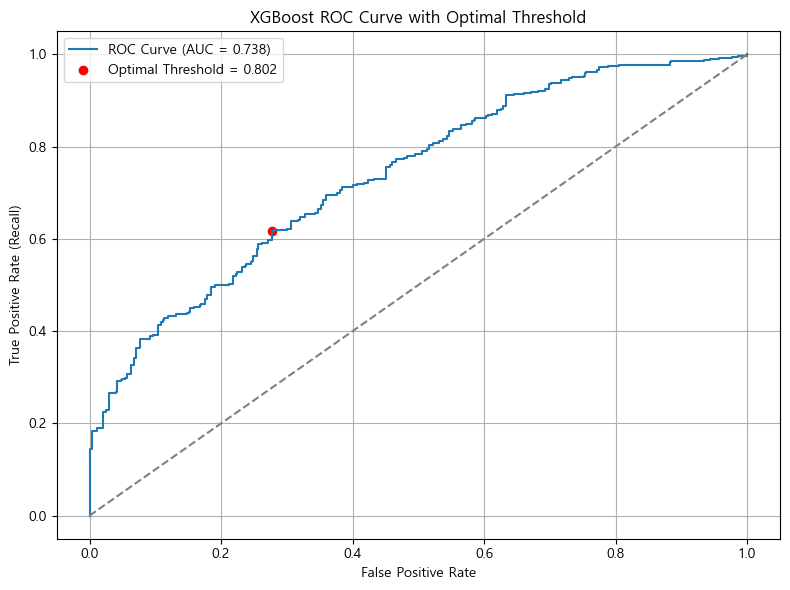

In [264]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

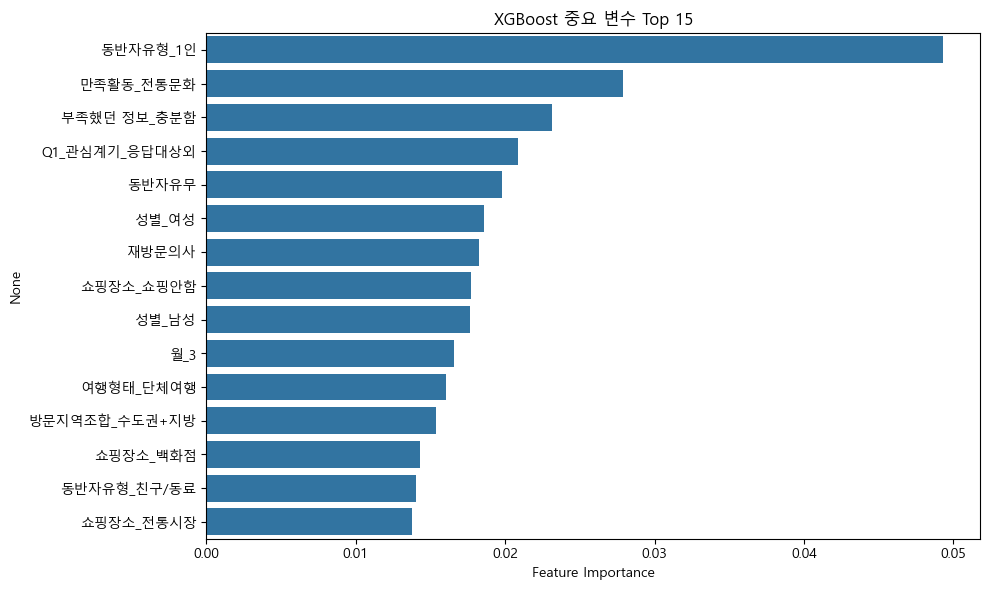

In [265]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

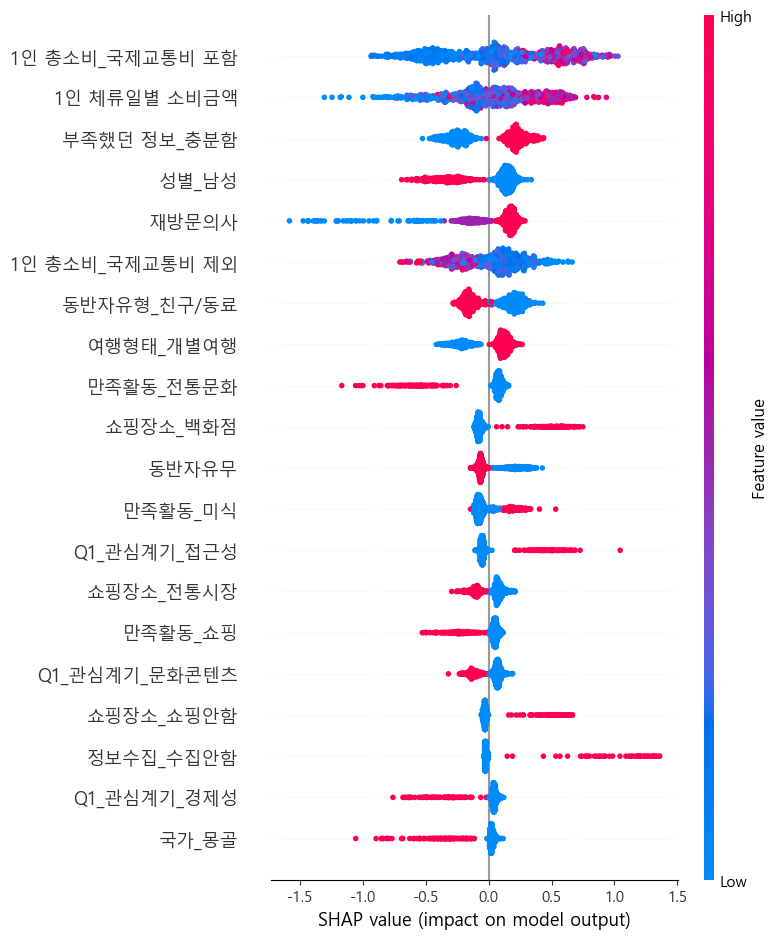

In [266]:
explainer = shap.Explainer(model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test, plot_type="dot")

In [267]:
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    w_tr, w_te = weights.iloc[train_idx], weights.iloc[test_idx]

    model_cv = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model_cv.fit(X_tr, y_tr, sample_weight=w_tr)
    y_prob = model_cv.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob, sample_weight=w_te)
    auc_scores.append(auc)

print("▶ Cross-Validation AUC Scores:", auc_scores)
print("▶ Mean AUC:", np.mean(auc_scores))
print("▶ Std AUC :", np.std(auc_scores))

▶ Cross-Validation AUC Scores: [0.7461199357348982, 0.7324878516540583, 0.7753154906245262, 0.7401012497789148, 0.7336233741022371]
▶ Mean AUC: 0.7455295803789269
▶ Std AUC : 0.015677118215695132


### (2) 그리드 서치 모델

| 단계 | 파라미터                               | 설명          |
| -- | ---------------------------------- | ----------- |
| ①  | `max_depth`, `min_child_weight`    | 모델 복잡도 조절   |
| ②  | `subsample`, `colsample_bytree`    | 과적합 방지      |
| ③  | `learning_rate`, `n_estimators`    | 학습 속도/횟수 조절 |
| ④  | `gamma`, `reg_alpha`, `reg_lambda` | 규제 조절       |


In [268]:
# 1단계 파라미터 그리드
param_grid_1 = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5]
}

# 기본 모델
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    subsample=1,
    colsample_bytree=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_1 = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_1,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_1.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_1.best_params_)
print("Best AUC Score:", grid_search_1.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 3, 'min_child_weight': 1}
Best AUC Score: 0.7196429219031044


In [269]:
# 1단계 결과 반영
best_model_1 = grid_search_1.best_estimator_
best_max_depth        = best_model_1.get_params()['max_depth']
best_min_child_weight = best_model_1.get_params()['min_child_weight']

# 2단계 파라미터 그리드
param_grid_2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 1단계 최적값을 고정한 모델
xgb_clf_2 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_2 = GridSearchCV(
    estimator=xgb_clf_2,
    param_grid=param_grid_2,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_2.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (2단계):", grid_search_2.best_params_)
print("Best AUC Score:", grid_search_2.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (2단계): {'colsample_bytree': 1.0, 'subsample': 0.6}
Best AUC Score: 0.7284724053326229


In [270]:
# 2단계까지 결과 반영
best_model_2 = grid_search_2.best_estimator_
best_max_depth        = best_model_2.get_params()['max_depth']
best_min_child_weight = best_model_2.get_params()['min_child_weight']
best_subsample        = best_model_2.get_params()['subsample']
best_colsample_bytree = best_model_2.get_params()['colsample_bytree']

# 3단계 파라미터 그리드
param_grid_3 = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# 이전 최적값을 고정한 모델
xgb_clf_3 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_3 = GridSearchCV(
    estimator=xgb_clf_3,
    param_grid=param_grid_3,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_3.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (3단계):", grid_search_3.best_params_)
print("Best AUC Score:", grid_search_3.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (3단계): {'learning_rate': 0.01, 'n_estimators': 300}
Best AUC Score: 0.7422781138693306


In [271]:
# 3단계까지 결과 반영
best_model_3 = grid_search_3.best_estimator_
best_max_depth        = best_model_3.get_params()['max_depth']
best_min_child_weight = best_model_3.get_params()['min_child_weight']
best_subsample        = best_model_3.get_params()['subsample']
best_colsample_bytree = best_model_3.get_params()['colsample_bytree']
best_learning_rate    = best_model_3.get_params()['learning_rate']
best_n_estimators     = best_model_3.get_params()['n_estimators']

# 4단계 파라미터 그리드
param_grid_4 = {
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

# 이전 최적값을 고정한 모델
xgb_clf_4 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_4 = GridSearchCV(
    estimator=xgb_clf_4,
    param_grid=param_grid_4,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_4.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (4단계):", grid_search_4.best_params_)
print("Best AUC Score:", grid_search_4.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters (4단계): {'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.5}
Best AUC Score: 0.7423839364143244


In [272]:
best_model = grid_search_4.best_estimator_

In [273]:
best_params_4 = grid_search_4.best_params_

best_max_depth        = best_model.get_params()['max_depth']
best_min_child_weight = best_model.get_params()['min_child_weight']
best_subsample        = best_model.get_params()['subsample']
best_colsample_bytree = best_model.get_params()['colsample_bytree']
best_learning_rate    = best_model.get_params()['learning_rate']
best_n_estimators     = best_model.get_params()['n_estimators']
best_gamma            = best_params_4.get('gamma', 0)
best_reg_alpha        = best_params_4.get('reg_alpha', 0)
best_reg_lambda       = best_params_4.get('reg_lambda', 1)

In [274]:
print("▶ 최적 파라미터")
print(f"max_depth        = {best_max_depth}")
print(f"min_child_weight = {best_min_child_weight}")
print(f"subsample        = {best_subsample}")
print(f"colsample_bytree = {best_colsample_bytree}")
print(f"learning_rate    = {best_learning_rate}")
print(f"n_estimators     = {best_n_estimators}")
print(f"gamma            = {best_gamma}")
print(f"reg_alpha        = {best_reg_alpha}")
print(f"reg_lambda       = {best_reg_lambda}")

▶ 최적 파라미터
max_depth        = 3
min_child_weight = 1
subsample        = 0.6
colsample_bytree = 1.0
learning_rate    = 0.01
n_estimators     = 300
gamma            = 0
reg_alpha        = 1.0
reg_lambda       = 1.5


In [275]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))


▶ [XGBoost 결과: Threshold = 0.754]
Accuracy     : 0.686
Precision    : 0.890
Recall       : 0.637
F1 Score     : 0.743
ROC AUC      : 0.777

▶ [분류 리포트]


              precision    recall  f1-score   support

           0      0.474     0.806     0.597 301928.2254921855
           1      0.890     0.637     0.743 743330.4223923188

    accuracy                          0.686 1045258.6478845044
   macro avg      0.682     0.722     0.670 1045258.6478845044
weighted avg      0.770     0.686     0.701 1045258.6478845044


▶ [혼동 행렬]
[[190  52]
 [240 441]]


클래스별 개수:
재방문여부
1    2269
0     805
Name: count, dtype: int64

클래스별 비율 (%):
재방문여부
1    73.81
0    26.19
Name: proportion, dtype: float64


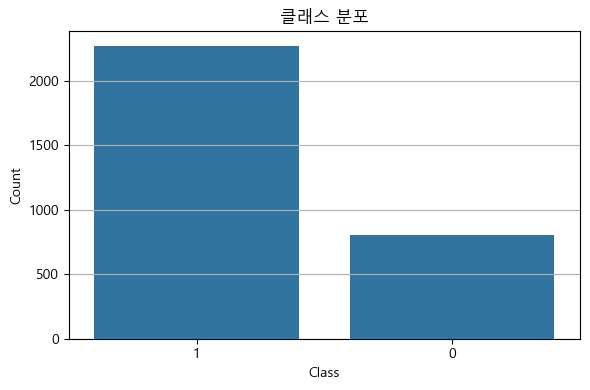

In [276]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스 분포 개수
class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

print("클래스별 개수:")
print(class_counts)
print("\n클래스별 비율 (%):")
print(class_percent.round(2))

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("클래스 분포")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

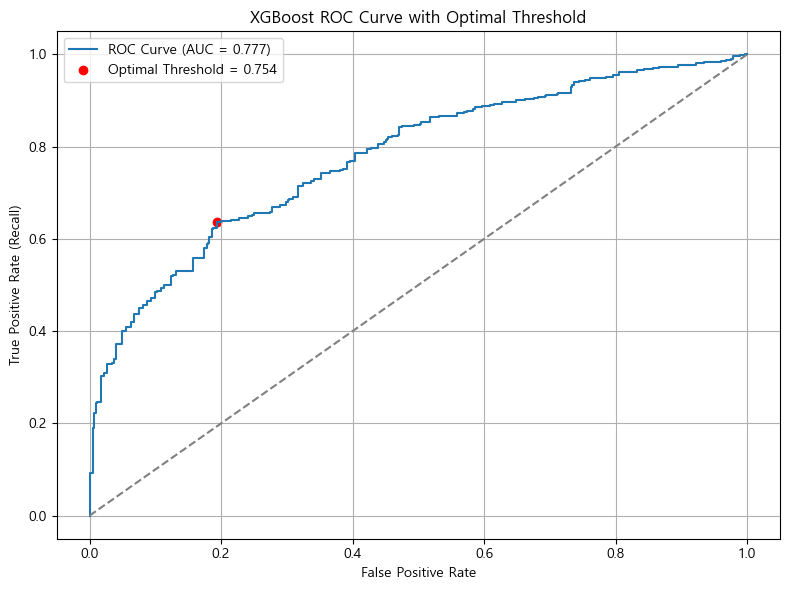

In [277]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

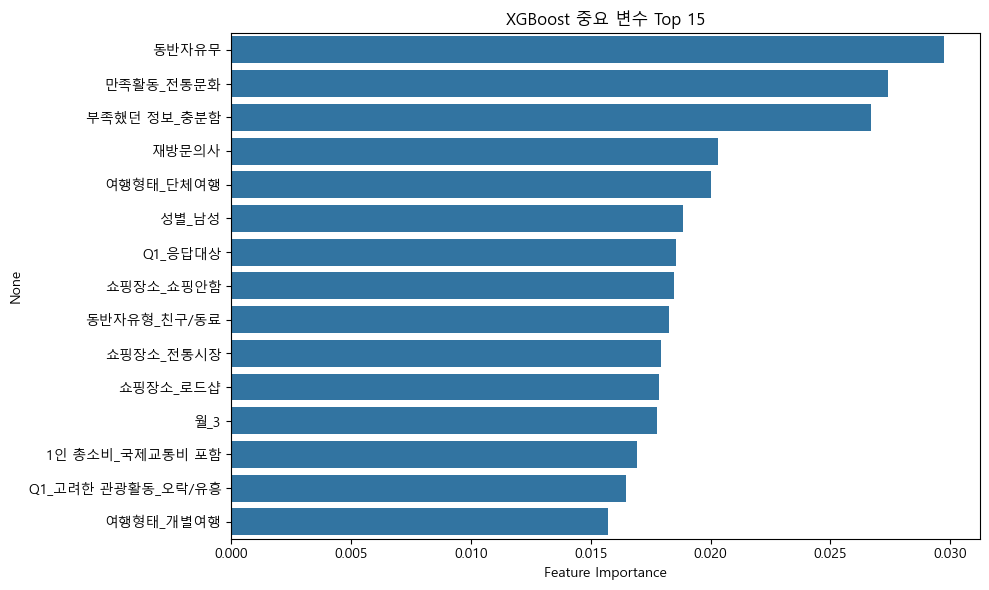

In [278]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

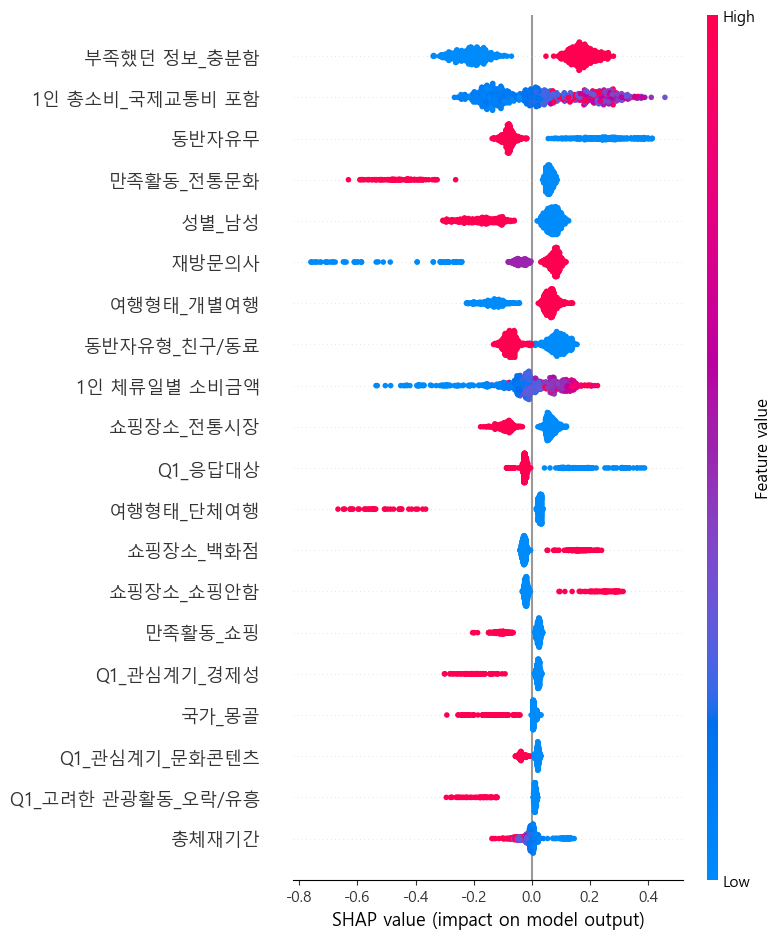

In [279]:
explainer = shap.Explainer(best_model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")

In [280]:
# 4단계 최종 모델을 그대로 사용
final_model = XGBClassifier(**best_model.get_params())

In [281]:
# StratifiedKFold 정의
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# AUC 기준으로 교차검증 수행
cv_scores = cross_val_score(
    final_model,
    X,
    y,
    cv=cv,
    scoring='roc_auc'
)

# 결과 출력
print("▶ Cross-Validation AUC Scores:", cv_scores)
print("▶ Mean AUC:", np.mean(cv_scores))
print("▶ Std AUC:", np.std(cv_scores))

▶ Cross-Validation AUC Scores: [0.77173229 0.73752976 0.78715079 0.74469861 0.77961965]
▶ Mean AUC: 0.7641462192896734
▶ Std AUC: 0.01955930288043996


### (3) 시뮬레이션 - 타깃에 대해

### 최종 모델이 기본 모델일 때

#### 가중치 반영 X ver

In [282]:
# ─────────── 기본 모델 기반 시뮬레이션 ───────────
# 조건부 타깃
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['Q1_관심계기_행사'] == False) &
    (X_test['Q1_고려한 관광활동_전통문화'] == False)
)
X_target = X_test[target_mask].copy()
proba_before = model.predict_proba(X_target)[:, 1]

# 단일 선택형 변수 처리
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
# 고려한 관광활동 변수 리스트
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]


# 변수 개입 시나리오 적용
X_sim = X_target.copy()
X_sim[travel_cols] = False
X_sim['여행형태_개별여행'] = True

X_sim[interest_cols] = False
X_sim['Q1_관심계기_행사'] = True

X_sim[activity_cols] = False
X_sim['Q1_고려한 관광활동_전통문화'] = True

# 변화 후 예측 및 요약
proba_after = model.predict_proba(X_sim)[:, 1]
delta = proba_after - proba_before #delta = After - Before는 정책 개입의 기대 효과 (확률 기준 변화량)
summary_model = pd.DataFrame({'Before': proba_before, 'After': proba_after, 'Change': delta})

#개입 후 예측 확률이 optimal_threshold를 넘으면 재방문 가능성 상승자로 간주
#“정책 개입 시 얼마나 많은 사람들이 재방문자로 바뀔 가능성이 있는가”를 판단
summary_model['Lifted'] = (summary_model['After'] >= optimal_threshold).astype(int)

# 분석 요약 출력
print("\n[기본 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_model)}")
print(f"▶ 평균 확률 변화        : {delta.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_model['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_model['Lifted'].mean() * 100:.2f}%")
# 예를 들어 재방문 확률 0.25였는데, 변수 조작 후에는 0.88로 상승
print(f"▶ 최대 변화             : {delta.max():.4f}")
# -이면 오히려 감소한 경우
print(f"▶ 최소 변화             : {delta.min():.4f}")



[기본 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 79
▶ 평균 확률 변화        : 0.1811
▶ 재방문 확률 상승자 수 : 50명
▶ 상승 비율             : 63.29%
▶ 최대 변화             : 0.4970
▶ 최소 변화             : -0.0897


#### 가중치 반영 O ver

In [283]:
# ─────────── 조건부 타깃 정의 ───────────
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['Q1_관심계기_행사'] == False) &
    (X_test['Q1_고려한 관광활동_전통문화'] == False)
)
X_target_gs = X_test[target_mask].copy()
weights_target_gs = w_test[target_mask].copy()  # 🎯 가중치 추출

# ─────────── 단일 선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim_gs = X_target_gs.copy()
X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs[interest_cols] = False
X_sim_gs['Q1_관심계기_행사'] = True

X_sim_gs[activity_cols] = False
X_sim_gs['Q1_고려한 관광활동_전통문화'] = True

# ─────────── 예측 및 변화량 계산 ───────────
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# ─────────── threshold 계산 (전체 test 기준) ───────────
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_gs = pd.DataFrame({
    'Before': proba_before_gs,
    'After': proba_after_gs,
    'Change': delta_gs
})
summary_gs['Lifted'] = (summary_gs['After'] >= optimal_threshold_gs).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array_gs = weights_target_gs.to_numpy()
assert len(weights_array_gs) == len(delta_gs), "가중치와 delta 길이 불일치"

# 평균 변화량
weighted_mean_delta_gs = np.average(delta_gs, weights=weights_array_gs)

# 상승자 가중치 합
lifted_weights_gs = weights_array_gs[summary_gs['Lifted'].to_numpy() == 1]
weighted_lifted_sum_gs = lifted_weights_gs.sum()

# 전체 가중 타깃 수
total_weight_gs = weights_array_gs.sum()

# 상승 비율
weighted_lifted_ratio_gs = (weighted_lifted_sum_gs / total_weight_gs) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_lift_idx = np.argmax(delta_gs)
bottom_lift_idx = np.argmin(delta_gs)

# ─────────── 전체 비재방문자 중 타깃 비중 계산 ───────────

# 전체 비재방문자 가중치 합
non_repeat_mask_all = (y_test == 0)
total_nonrepeat_weight = w_test[non_repeat_mask_all].sum()

# 조건부 타깃 비중 (%)
target_weight_ratio = (total_weight_gs / total_nonrepeat_weight) * 100

# ─────────── 최종 출력 ───────────
print("\n📘 [그리드서치 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]")
print(f"▶ 가중 타깃 수             : {total_weight_gs:.0f}명")
print(f"▶ 조건부 타깃 비중 (전체 비재방문자 중) : {target_weight_ratio:.2f}%")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta_gs:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum_gs:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio_gs:.2f}%")
print(f"▶ 최대 변화                : {delta_gs.max():.4f}")
print(f"▶ 최소 변화                : {delta_gs.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before_gs[top_lift_idx]:.4f} → {proba_after_gs[top_lift_idx]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before_gs[bottom_lift_idx]:.4f} → {proba_after_gs[bottom_lift_idx]:.4f}")



📘 [그리드서치 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]
▶ 가중 타깃 수             : 116608명
▶ 조건부 타깃 비중 (전체 비재방문자 중) : 38.62%
▶ 평균 확률 변화 (가중)    : 0.0691
▶ 재방문 상승자 수 (가중)  : 32849명
▶ 상승 비율 (가중)         : 28.17%
▶ 최대 변화                : 0.2781
▶ 최소 변화                : -0.0112
▶ 변화량 최댓값 응답자 Before/After: 0.4221 → 0.7002
▶ 변화량 최솟값 응답자 Before/After: 0.6264 → 0.6152


### 최종 모델이 그리드 서치 모델일때

#### 가중치 반영 X ver

In [284]:
# ─────────── 그리드서치 최적 모델 기반 시뮬레이션 ───────────
# 조건부 타깃 재사용
X_target_gs = X_test[target_mask].copy()
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]

# 변수 개입 동일하게 적용
X_sim_gs = X_target_gs.copy()
X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs[interest_cols] = False
X_sim_gs['Q1_관심계기_행사'] = True

X_sim_gs['Q1_고려한 관광활동_전통문화'] = True

# 변화 후 예측 및 요약
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# 전체 test 세트 기준 best_model용 threshold 계산
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_best = pd.DataFrame({'Before': proba_before_gs, 'After': proba_after_gs, 'Change': delta_gs})
summary_best['Lifted'] = (summary_best['After'] >= optimal_threshold_gs).astype(int)

# 분석 요약 출력
print("\n[그리드서치 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_best)}")
print(f"▶ 평균 확률 변화        : {delta_gs.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_best['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_best['Lifted'].mean() * 100:.2f}%")
print(f"▶ 최대 변화             : {delta_gs.max():.4f}")
print(f"▶ 최소 변화             : {delta_gs.min():.4f}")



[그리드서치 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 79
▶ 평균 확률 변화        : 0.0706
▶ 재방문 확률 상승자 수 : 24명
▶ 상승 비율             : 30.38%
▶ 최대 변화             : 0.2626
▶ 최소 변화             : -0.0112


#### 가중치 반영 O ver

In [285]:
# ─────────── 조건부 타깃 정의 ───────────
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['Q1_관심계기_행사'] == False) &
    (X_test['Q1_고려한 관광활동_전통문화'] == False)
)
X_target_gs = X_test[target_mask].copy()
weights_target_gs = w_test[target_mask].copy()  # 🎯 가중치 추출

# ─────────── 단일 선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim_gs = X_target_gs.copy()
X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs[interest_cols] = False
X_sim_gs['Q1_관심계기_행사'] = True

X_sim_gs[activity_cols] = False
X_sim_gs['Q1_고려한 관광활동_전통문화'] = True

# ─────────── 예측 및 변화량 계산 ───────────
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# ─────────── threshold 계산 (전체 test 기준) ───────────
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_gs = pd.DataFrame({
    'Before': proba_before_gs,
    'After': proba_after_gs,
    'Change': delta_gs
})
summary_gs['Lifted'] = (summary_gs['After'] >= optimal_threshold_gs).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array_gs = weights_target_gs.to_numpy()
assert len(weights_array_gs) == len(delta_gs), "가중치와 delta 길이 불일치"

# 평균 변화량
weighted_mean_delta_gs = np.average(delta_gs, weights=weights_array_gs)

# 상승자 가중치 합
lifted_weights_gs = weights_array_gs[summary_gs['Lifted'].to_numpy() == 1]
weighted_lifted_sum_gs = lifted_weights_gs.sum()

# 전체 가중 타깃 수
total_weight_gs = weights_array_gs.sum()

# 상승 비율
weighted_lifted_ratio_gs = (weighted_lifted_sum_gs / total_weight_gs) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_lift_idx = np.argmax(delta_gs)
bottom_lift_idx = np.argmin(delta_gs)

# ─────────── 최종 출력 ───────────
print("\n📘 [그리드서치 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]")
print(f"▶ 가중 타깃 수             : {total_weight_gs:.0f}명")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta_gs:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum_gs:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio_gs:.2f}%")
print(f"▶ 최대 변화                : {delta_gs.max():.4f}")
print(f"▶ 최소 변화                : {delta_gs.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before_gs[top_lift_idx]:.4f} → {proba_after_gs[top_lift_idx]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before_gs[bottom_lift_idx]:.4f} → {proba_after_gs[bottom_lift_idx]:.4f}")



📘 [그리드서치 모델 기반 시뮬레이션 결과 요약 - 가중치 반영]
▶ 가중 타깃 수             : 116608명
▶ 평균 확률 변화 (가중)    : 0.0691
▶ 재방문 상승자 수 (가중)  : 32849명
▶ 상승 비율 (가중)         : 28.17%
▶ 최대 변화                : 0.2781
▶ 최소 변화                : -0.0112
▶ 변화량 최댓값 응답자 Before/After: 0.4221 → 0.7002
▶ 변화량 최솟값 응답자 Before/After: 0.6264 → 0.6152


### (4) 시뮬레이션 - 전체 비재방문객에 대해

### 최종 모델이 기본 모델일 때

#### 가중치 반영 X ver

In [286]:
# ─────────── 전체 재방문X 대상: 기본 모델 ───────────

# 전체 재방문여부 = 0인 응답자
X_all = X_test.copy()
non_repeat_mask = (y_test == 0)
X_non_repeat = X_all[non_repeat_mask].copy()
proba_before_all = model.predict_proba(X_non_repeat)[:, 1]

# 단일선택형 변수 그룹
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# 변수 개입
X_sim_all = X_non_repeat.copy()
X_sim_all[travel_cols] = False
X_sim_all['여행형태_개별여행'] = True
X_sim_all[interest_cols] = False
X_sim_all['Q1_관심계기_행사'] = True
X_sim_all[activity_cols] = False
X_sim_all['Q1_고려한 관광활동_전통문화'] = True

# 예측 및 변화량
proba_after_all = model.predict_proba(X_sim_all)[:, 1]
delta_all = proba_after_all - proba_before_all

summary_all = pd.DataFrame({
    'Before': proba_before_all,
    'After': proba_after_all,
    'Change': delta_all
})
summary_all['Lifted'] = (summary_all['After'] >= optimal_threshold).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 기본 모델]")
print(f"▶ 전체 대상 수           : {len(summary_all)}")
print(f"▶ 평균 확률 변화         : {delta_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 기본 모델]
▶ 전체 대상 수           : 242
▶ 평균 확률 변화         : 0.0935
▶ 재방문 가능성 상승자 수 : 115명
▶ 상승 비율               : 47.52%
▶ 최대 변화               : 0.4970
▶ 최소 변화               : -0.2250


#### 가중치 반영 O ver

In [287]:
# ─────────── 전체 재방문X 대상: 기본 모델 ───────────

# 전체 재방문여부 = 0인 응답자
non_repeat_mask = (y_test == 0)
X_non_repeat = X_test[non_repeat_mask].copy()
weights_non_repeat = w_test[non_repeat_mask].copy()

# 예측 전 확률
proba_before_all = model.predict_proba(X_non_repeat)[:, 1]

# ─────────── 단일선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim_all = X_non_repeat.copy()
X_sim_all[travel_cols] = False
X_sim_all['여행형태_개별여행'] = True

X_sim_all[interest_cols] = False
X_sim_all['Q1_관심계기_행사'] = True

X_sim_all[activity_cols] = False
X_sim_all['Q1_고려한 관광활동_전통문화'] = True

# ─────────── 예측 및 변화량 계산 ───────────
proba_after_all = model.predict_proba(X_sim_all)[:, 1]
delta_all = proba_after_all - proba_before_all

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_all = pd.DataFrame({
    'Before': proba_before_all,
    'After': proba_after_all,
    'Change': delta_all
})
summary_all['Lifted'] = (summary_all['After'] >= optimal_threshold).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array_all = weights_non_repeat.to_numpy()

# 평균 확률 변화 (가중)
weighted_mean_delta_all = np.average(delta_all, weights=weights_array_all)

# 재방문 확률 상승자 수 (가중치 합)
lifted_weights_all = weights_array_all[summary_all['Lifted'].to_numpy() == 1]
weighted_lifted_sum_all = lifted_weights_all.sum()

# 전체 가중 대상 수
total_weight_all = weights_array_all.sum()

# 상승 비율 (가중 기준)
weighted_lifted_ratio_all = (weighted_lifted_sum_all / total_weight_all) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_idx_all = np.argmax(delta_all)
bottom_idx_all = np.argmin(delta_all)

# ─────────── 최종 출력 ───────────
print("\n📘 [전체 비재방문자 시뮬레이션 - 기본 모델, 가중치 반영]")
print(f"▶ 가중 대상 수             : {total_weight_all:.0f}명")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta_all:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum_all:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio_all:.2f}%")
print(f"▶ 최대 변화                : {delta_all.max():.4f}")
print(f"▶ 최소 변화                : {delta_all.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before_all[top_idx_all]:.4f} → {proba_after_all[top_idx_all]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before_all[bottom_idx_all]:.4f} → {proba_after_all[bottom_idx_all]:.4f}")



📘 [전체 비재방문자 시뮬레이션 - 기본 모델, 가중치 반영]
▶ 가중 대상 수             : 301928명
▶ 평균 확률 변화 (가중)    : 0.1063
▶ 재방문 상승자 수 (가중)  : 164350명
▶ 상승 비율 (가중)         : 54.43%
▶ 최대 변화                : 0.4970
▶ 최소 변화                : -0.2250
▶ 변화량 최댓값 응답자 Before/After: 0.4087 → 0.9057
▶ 변화량 최솟값 응답자 Before/After: 0.6387 → 0.4137


### 최종 모델이 그리드 서치 모델일 때

#### 가중치 반영 X ver

In [288]:
# ─────────── 전체 재방문X 대상: 그리드서치 모델 ───────────

# 대상 재사용
X_non_repeat_gs = X_test[y_test == 0].copy()
proba_before_gs_all = best_model.predict_proba(X_non_repeat_gs)[:, 1]

# 변수 개입
X_sim_gs_all = X_non_repeat_gs.copy()
X_sim_gs_all[travel_cols] = False
X_sim_gs_all['여행형태_개별여행'] = True
X_sim_gs_all[interest_cols] = False
X_sim_gs_all['Q1_관심계기_행사'] = True
X_sim_gs_all[activity_cols] = False
X_sim_gs_all['Q1_고려한 관광활동_전통문화'] = True

# 예측 및 변화량
proba_after_gs_all = best_model.predict_proba(X_sim_gs_all)[:, 1]
delta_gs_all = proba_after_gs_all - proba_before_gs_all

# best_model용 threshold 재계산 (전체 test 기준)
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_gs_all = pd.DataFrame({
    'Before': proba_before_gs_all,
    'After': proba_after_gs_all,
    'Change': delta_gs_all
})
summary_gs_all['Lifted'] = (summary_gs_all['After'] >= optimal_threshold_gs).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]")
print(f"▶ 전체 대상 수           : {len(summary_gs_all)}")
print(f"▶ 평균 확률 변화         : {delta_gs_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_gs_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_gs_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_gs_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_gs_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]
▶ 전체 대상 수           : 242
▶ 평균 확률 변화         : 0.0349
▶ 재방문 가능성 상승자 수 : 68명
▶ 상승 비율               : 28.10%
▶ 최대 변화               : 0.2781
▶ 최소 변화               : -0.0495


#### 가중치 반영 O ver

In [289]:
# ─────────── 전체 재방문X 대상: 그리드서치 모델 ───────────

# 대상 필터
non_repeat_mask_gs = (y_test == 0)
X_non_repeat_gs = X_test[non_repeat_mask_gs].copy()
weights_non_repeat_gs = w_test[non_repeat_mask_gs].copy()

# 예측 전 확률
proba_before_gs_all = best_model.predict_proba(X_non_repeat_gs)[:, 1]

# ─────────── 단일선택형 변수 그룹 정의 ───────────
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# ─────────── 변수 개입 시나리오 적용 ───────────
X_sim_gs_all = X_non_repeat_gs.copy()
X_sim_gs_all[travel_cols] = False
X_sim_gs_all['여행형태_개별여행'] = True

X_sim_gs_all[interest_cols] = False
X_sim_gs_all['Q1_관심계기_행사'] = True

X_sim_gs_all[activity_cols] = False
X_sim_gs_all['Q1_고려한 관광활동_전통문화'] = True

# ─────────── 예측 및 변화량 계산 ───────────
proba_after_gs_all = best_model.predict_proba(X_sim_gs_all)[:, 1]
delta_gs_all = proba_after_gs_all - proba_before_gs_all

# ─────────── threshold 재계산 (전체 test 기준) ───────────
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

# ─────────── 결과 요약 테이블 ───────────
import pandas as pd
import numpy as np

summary_gs_all = pd.DataFrame({
    'Before': proba_before_gs_all,
    'After': proba_after_gs_all,
    'Change': delta_gs_all
})
summary_gs_all['Lifted'] = (summary_gs_all['After'] >= optimal_threshold_gs).astype(int)

# ─────────── 가중 통계 계산 ───────────
weights_array_gs_all = weights_non_repeat_gs.to_numpy()

# 평균 확률 변화 (가중)
weighted_mean_delta_gs_all = np.average(delta_gs_all, weights=weights_array_gs_all)

# 재방문 상승자 가중치 합
lifted_weights_gs_all = weights_array_gs_all[summary_gs_all['Lifted'].to_numpy() == 1]
weighted_lifted_sum_gs_all = lifted_weights_gs_all.sum()

# 전체 가중 대상 수
total_weight_gs_all = weights_array_gs_all.sum()

# 상승 비율 (가중)
weighted_lifted_ratio_gs_all = (weighted_lifted_sum_gs_all / total_weight_gs_all) * 100

# ─────────── 변화량 최댓값/최솟값 응답자 ───────────
top_idx_gs_all = np.argmax(delta_gs_all)
bottom_idx_gs_all = np.argmin(delta_gs_all)

# ─────────── 최종 출력 ───────────
print("\n📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델, 가중치 반영]")
print(f"▶ 가중 대상 수             : {total_weight_gs_all:.0f}명")
print(f"▶ 평균 확률 변화 (가중)    : {weighted_mean_delta_gs_all:.4f}")
print(f"▶ 재방문 상승자 수 (가중)  : {weighted_lifted_sum_gs_all:.0f}명")
print(f"▶ 상승 비율 (가중)         : {weighted_lifted_ratio_gs_all:.2f}%")
print(f"▶ 최대 변화                : {delta_gs_all.max():.4f}")
print(f"▶ 최소 변화                : {delta_gs_all.min():.4f}")
print(f"▶ 변화량 최댓값 응답자 Before/After: {proba_before_gs_all[top_idx_gs_all]:.4f} → {proba_after_gs_all[top_idx_gs_all]:.4f}")
print(f"▶ 변화량 최솟값 응답자 Before/After: {proba_before_gs_all[bottom_idx_gs_all]:.4f} → {proba_after_gs_all[bottom_idx_gs_all]:.4f}")


📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델, 가중치 반영]
▶ 가중 대상 수             : 301928명
▶ 평균 확률 변화 (가중)    : 0.0347
▶ 재방문 상승자 수 (가중)  : 75876명
▶ 상승 비율 (가중)         : 25.13%
▶ 최대 변화                : 0.2781
▶ 최소 변화                : -0.0495
▶ 변화량 최댓값 응답자 Before/After: 0.4221 → 0.7002
▶ 변화량 최솟값 응답자 Before/After: 0.7458 → 0.6963
